## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128], 
              regul=None, dropout_rate=0, batch_normal=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if regul is None:
                x = keras.layers.Dense(
                units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            else:
                x = keras.layers.Dense(
                    units=n_units, activation='relu', name='hidden_layer'+str(i+1),
                    kernel_regularizer=regul(1e-4))(input_layer)
        else:
            if regul is None:
                x = keras.layers.Dense(
                    units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
            else:
                x = keras.layers.Dense(
                    units=n_units, activation='relu', name='hidden_layer'+str(i+1),
                    kernel_regularizer=regul(1e-4))(x)

        if dropout_rate != 0:
            keras.layers.Dropout(dropout_rate)(x)

        if batch_normal:
            keras.layers.BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
#from keras.regularizers import l1,l2
"""Code Here
設定超參數
"""
BATCH_SIZE=500
EPOCHS=50
LEARNING_RATE=1e-3
REGULARIZER=[None, keras.regularizers.l1, keras.regularizers.l2]
DROPOUT_RATE=[0,0.1,0.2]
BATCH_NORMAL=[False, True]

In [7]:
results1 = {}
results2 = {}
results3 = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, regul in enumerate(REGULARIZER):
    for drop_rate in DROPOUT_RATE:
        for batch_nor in BATCH_NORMAL:
            print('REGULARIZER=%s / DROPOUT_RATE=%s / BATCH_NORMAL=%s' %(str(regul), str(drop_rate), str(batch_nor)))
            model = build_mlp(x_train.shape[1:], regul=regul, dropout_rate=drop_rate, batch_normal=batch_nor)
            model.summary()
            
            sgd = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=0.95, nesterov=True)
            model.compile(metrics=['accuracy'], loss="categorical_crossentropy", optimizer=sgd)
            model.fit(x_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      validation_data=(x_test, y_test),
                      shuffle=True)
            
            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]
            
            if i == 0:
                results = results1
            elif i == 1:
                results = results2
            elif i == 2:
                results = results3
                
            exp_name_tag = "exp-dropout rate %s-batch normal %s" % (str(drop_rate), str(batch_nor))
            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

REGULARIZER=None / DROPOUT_RATE=0 / BATCH_NORMAL=False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50

50000/50000 [==============================] - 11s 214us/step - loss: 1.1339 - accuracy: 0.6036 - val_loss: 1.3277 - val_accuracy: 0.5277
Epoch 49/50
50000/50000 [==============================] - 11s 224us/step - loss: 1.1250 - accuracy: 0.6060 - val_loss: 1.3408 - val_accuracy: 0.5277
Epoch 50/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.1163 - accuracy: 0.6094 - val_loss: 1.3318 - val_accuracy: 0.5309
REGULARIZER=None / DROPOUT_RATE=0 / BATCH_NORMAL=True
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________

50000/50000 [==============================] - 14s 270us/step - loss: 1.1637 - accuracy: 0.5936 - val_loss: 1.3497 - val_accuracy: 0.5207
Epoch 46/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.1556 - accuracy: 0.5956 - val_loss: 1.3368 - val_accuracy: 0.5265
Epoch 47/50
50000/50000 [==============================] - 13s 255us/step - loss: 1.1465 - accuracy: 0.5994 - val_loss: 1.3496 - val_accuracy: 0.5242
Epoch 48/50
50000/50000 [==============================] - 11s 219us/step - loss: 1.1389 - accuracy: 0.6037 - val_loss: 1.3340 - val_accuracy: 0.5283
Epoch 49/50
50000/50000 [==============================] - 11s 224us/step - loss: 1.1300 - accuracy: 0.6043 - val_loss: 1.3688 - val_accuracy: 0.5173
Epoch 50/50
50000/50000 [==============================] - 11s 218us/step - loss: 1.1183 - accuracy: 0.6104 - val_loss: 1.3350 - val_accuracy: 0.5275
REGULARIZER=None / DROPOUT_RATE=0.1 / BATCH_NORMAL=False
Model: "model_3"
______________________________________

50000/50000 [==============================] - 13s 261us/step - loss: 1.1947 - accuracy: 0.5806 - val_loss: 1.3432 - val_accuracy: 0.5259
Epoch 43/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.1853 - accuracy: 0.5834 - val_loss: 1.3459 - val_accuracy: 0.5201
Epoch 44/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.1762 - accuracy: 0.5866 - val_loss: 1.3367 - val_accuracy: 0.5243
Epoch 45/50
50000/50000 [==============================] - 13s 265us/step - loss: 1.1672 - accuracy: 0.5892 - val_loss: 1.3369 - val_accuracy: 0.5215
Epoch 46/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.1590 - accuracy: 0.5933 - val_loss: 1.3398 - val_accuracy: 0.5249
Epoch 47/50
50000/50000 [==============================] - 13s 260us/step - loss: 1.1484 - accuracy: 0.5973 - val_loss: 1.3373 - val_accuracy: 0.5252
Epoch 48/50
50000/50000 [==============================] - 13s 261us/step - loss: 1.1434 - accuracy: 0.5996 - va

50000/50000 [==============================] - 8s 166us/step - loss: 1.2255 - accuracy: 0.5697 - val_loss: 1.3759 - val_accuracy: 0.5090
Epoch 40/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.2147 - accuracy: 0.5729 - val_loss: 1.3556 - val_accuracy: 0.5166
Epoch 41/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.2068 - accuracy: 0.5770 - val_loss: 1.3579 - val_accuracy: 0.5179
Epoch 42/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.1992 - accuracy: 0.5809 - val_loss: 1.3547 - val_accuracy: 0.5179
Epoch 43/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.1893 - accuracy: 0.5819 - val_loss: 1.3535 - val_accuracy: 0.5206
Epoch 44/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.1797 - accuracy: 0.5865 - val_loss: 1.3460 - val_accuracy: 0.5223
Epoch 45/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.1700 - accuracy: 0.5889 - val_

50000/50000 [==============================] - 14s 276us/step - loss: 1.2471 - accuracy: 0.5629 - val_loss: 1.3585 - val_accuracy: 0.5217
Epoch 37/50
50000/50000 [==============================] - 13s 270us/step - loss: 1.2372 - accuracy: 0.5647 - val_loss: 1.3529 - val_accuracy: 0.5227
Epoch 38/50
50000/50000 [==============================] - 14s 282us/step - loss: 1.2277 - accuracy: 0.5682 - val_loss: 1.3661 - val_accuracy: 0.5186
Epoch 39/50
50000/50000 [==============================] - 14s 284us/step - loss: 1.2189 - accuracy: 0.5726 - val_loss: 1.3533 - val_accuracy: 0.5219
Epoch 40/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.2116 - accuracy: 0.5763 - val_loss: 1.3736 - val_accuracy: 0.5125
Epoch 41/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.2013 - accuracy: 0.5777 - val_loss: 1.3470 - val_accuracy: 0.5249
Epoch 42/50
50000/50000 [==============================] - 14s 279us/step - loss: 1.1902 - accuracy: 0.5827 - va

50000/50000 [==============================] - 13s 269us/step - loss: 1.2726 - accuracy: 0.5559 - val_loss: 1.3749 - val_accuracy: 0.5116
Epoch 34/50
50000/50000 [==============================] - 14s 277us/step - loss: 1.2625 - accuracy: 0.5591 - val_loss: 1.3771 - val_accuracy: 0.5091
Epoch 35/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.2522 - accuracy: 0.5645 - val_loss: 1.3704 - val_accuracy: 0.5141
Epoch 36/50
50000/50000 [==============================] - 14s 272us/step - loss: 1.2440 - accuracy: 0.5646 - val_loss: 1.3673 - val_accuracy: 0.5140
Epoch 37/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.2329 - accuracy: 0.5692 - val_loss: 1.3657 - val_accuracy: 0.5162
Epoch 38/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.2234 - accuracy: 0.5728 - val_loss: 1.3568 - val_accuracy: 0.5191
Epoch 39/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.2149 - accuracy: 0.5737 - va

50000/50000 [==============================] - 14s 287us/step - loss: 4.4259 - accuracy: 0.5317 - val_loss: 4.4800 - val_accuracy: 0.5038
Epoch 31/50
50000/50000 [==============================] - 14s 287us/step - loss: 4.3874 - accuracy: 0.5365 - val_loss: 4.4413 - val_accuracy: 0.5048
Epoch 32/50
50000/50000 [==============================] - 14s 286us/step - loss: 4.3515 - accuracy: 0.5385 - val_loss: 4.4070 - val_accuracy: 0.5084
Epoch 33/50
50000/50000 [==============================] - 15s 291us/step - loss: 4.3138 - accuracy: 0.5422 - val_loss: 4.3818 - val_accuracy: 0.5070
Epoch 34/50
50000/50000 [==============================] - 15s 294us/step - loss: 4.2757 - accuracy: 0.5451 - val_loss: 4.3526 - val_accuracy: 0.5078
Epoch 35/50
50000/50000 [==============================] - 14s 287us/step - loss: 4.2390 - accuracy: 0.5484 - val_loss: 4.3170 - val_accuracy: 0.5085
Epoch 36/50
50000/50000 [==============================] - 15s 290us/step - loss: 4.2030 - accuracy: 0.5506 - va

50000/50000 [==============================] - 12s 232us/step - loss: 4.5437 - accuracy: 0.5222 - val_loss: 4.5905 - val_accuracy: 0.4920
Epoch 28/50
50000/50000 [==============================] - 12s 234us/step - loss: 4.5030 - accuracy: 0.5278 - val_loss: 4.5546 - val_accuracy: 0.4976
Epoch 29/50
50000/50000 [==============================] - 12s 234us/step - loss: 4.4653 - accuracy: 0.5282 - val_loss: 4.5104 - val_accuracy: 0.5010
Epoch 30/50
50000/50000 [==============================] - 12s 233us/step - loss: 4.4262 - accuracy: 0.5328 - val_loss: 4.4815 - val_accuracy: 0.5042
Epoch 31/50
50000/50000 [==============================] - 12s 232us/step - loss: 4.3876 - accuracy: 0.5373 - val_loss: 4.4446 - val_accuracy: 0.5061
Epoch 32/50
50000/50000 [==============================] - 12s 230us/step - loss: 4.3516 - accuracy: 0.5388 - val_loss: 4.4142 - val_accuracy: 0.5087
Epoch 33/50
50000/50000 [==============================] - 12s 232us/step - loss: 4.3133 - accuracy: 0.5420 - va

50000/50000 [==============================] - 11s 227us/step - loss: 4.6668 - accuracy: 0.5088 - val_loss: 4.6988 - val_accuracy: 0.4869
Epoch 25/50
50000/50000 [==============================] - 11s 229us/step - loss: 4.6264 - accuracy: 0.5122 - val_loss: 4.6600 - val_accuracy: 0.4909
Epoch 26/50
50000/50000 [==============================] - 12s 231us/step - loss: 4.5852 - accuracy: 0.5151 - val_loss: 4.6236 - val_accuracy: 0.4924
Epoch 27/50
50000/50000 [==============================] - 12s 230us/step - loss: 4.5445 - accuracy: 0.5208 - val_loss: 4.5920 - val_accuracy: 0.4935
Epoch 28/50
50000/50000 [==============================] - 11s 229us/step - loss: 4.5066 - accuracy: 0.5228 - val_loss: 4.5560 - val_accuracy: 0.4948
Epoch 29/50
50000/50000 [==============================] - 11s 229us/step - loss: 4.4682 - accuracy: 0.5269 - val_loss: 4.5153 - val_accuracy: 0.5024
Epoch 30/50
50000/50000 [==============================] - 12s 232us/step - loss: 4.4282 - accuracy: 0.5325 - va

50000/50000 [==============================] - 11s 229us/step - loss: 4.7671 - accuracy: 0.5066 - val_loss: 4.7918 - val_accuracy: 0.4856
Epoch 22/50
50000/50000 [==============================] - 11s 228us/step - loss: 4.7238 - accuracy: 0.5117 - val_loss: 4.7599 - val_accuracy: 0.4864
Epoch 23/50
50000/50000 [==============================] - 12s 231us/step - loss: 4.6832 - accuracy: 0.5132 - val_loss: 4.7147 - val_accuracy: 0.4901
Epoch 24/50
50000/50000 [==============================] - 12s 230us/step - loss: 4.6419 - accuracy: 0.5171 - val_loss: 4.6767 - val_accuracy: 0.4957
Epoch 25/50
50000/50000 [==============================] - 12s 233us/step - loss: 4.6008 - accuracy: 0.5226 - val_loss: 4.6437 - val_accuracy: 0.4980
Epoch 26/50
50000/50000 [==============================] - 12s 234us/step - loss: 4.5612 - accuracy: 0.5268 - val_loss: 4.6057 - val_accuracy: 0.4964
Epoch 27/50
50000/50000 [==============================] - 12s 231us/step - loss: 4.5218 - accuracy: 0.5298 - va

50000/50000 [==============================] - 12s 234us/step - loss: 4.9189 - accuracy: 0.4866 - val_loss: 4.9262 - val_accuracy: 0.4708
Epoch 19/50
50000/50000 [==============================] - 11s 230us/step - loss: 4.8758 - accuracy: 0.4918 - val_loss: 4.8894 - val_accuracy: 0.4728
Epoch 20/50
50000/50000 [==============================] - 12s 237us/step - loss: 4.8316 - accuracy: 0.4944 - val_loss: 4.8489 - val_accuracy: 0.4787
Epoch 21/50
50000/50000 [==============================] - 12s 230us/step - loss: 4.7881 - accuracy: 0.4991 - val_loss: 4.8049 - val_accuracy: 0.4809
Epoch 22/50
50000/50000 [==============================] - 12s 232us/step - loss: 4.7450 - accuracy: 0.5027 - val_loss: 4.7707 - val_accuracy: 0.4836
Epoch 23/50
50000/50000 [==============================] - 12s 233us/step - loss: 4.7048 - accuracy: 0.5064 - val_loss: 4.7303 - val_accuracy: 0.4896
Epoch 24/50
50000/50000 [==============================] - 12s 231us/step - loss: 4.6634 - accuracy: 0.5111 - va

50000/50000 [==============================] - 12s 233us/step - loss: 5.0504 - accuracy: 0.4711 - val_loss: 5.0528 - val_accuracy: 0.4612
Epoch 16/50
50000/50000 [==============================] - 12s 235us/step - loss: 5.0063 - accuracy: 0.4749 - val_loss: 5.0073 - val_accuracy: 0.4635
Epoch 17/50
50000/50000 [==============================] - 12s 232us/step - loss: 4.9617 - accuracy: 0.4799 - val_loss: 4.9630 - val_accuracy: 0.4678
Epoch 18/50
50000/50000 [==============================] - 12s 233us/step - loss: 4.9166 - accuracy: 0.4852 - val_loss: 4.9261 - val_accuracy: 0.4695
Epoch 19/50
50000/50000 [==============================] - 12s 233us/step - loss: 4.8739 - accuracy: 0.4883 - val_loss: 4.8802 - val_accuracy: 0.4772
Epoch 20/50
50000/50000 [==============================] - 12s 235us/step - loss: 4.8301 - accuracy: 0.4932 - val_loss: 4.8441 - val_accuracy: 0.4793
Epoch 21/50
50000/50000 [==============================] - 12s 233us/step - loss: 4.7883 - accuracy: 0.4981 - va

50000/50000 [==============================] - 12s 232us/step - loss: 1.6933 - accuracy: 0.4573 - val_loss: 1.7037 - val_accuracy: 0.4501
Epoch 13/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.6747 - accuracy: 0.4627 - val_loss: 1.6862 - val_accuracy: 0.4575
Epoch 14/50
50000/50000 [==============================] - 12s 230us/step - loss: 1.6592 - accuracy: 0.4703 - val_loss: 1.6729 - val_accuracy: 0.4586
Epoch 15/50
50000/50000 [==============================] - 11s 228us/step - loss: 1.6415 - accuracy: 0.4754 - val_loss: 1.6607 - val_accuracy: 0.4619
Epoch 16/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.6270 - accuracy: 0.4786 - val_loss: 1.6504 - val_accuracy: 0.4677
Epoch 17/50
50000/50000 [==============================] - 11s 229us/step - loss: 1.6126 - accuracy: 0.4853 - val_loss: 1.6366 - val_accuracy: 0.4732
Epoch 18/50
50000/50000 [==============================] - 11s 229us/step - loss: 1.5977 - accuracy: 0.4895 - va

50000/50000 [==============================] - 12s 231us/step - loss: 1.7540 - accuracy: 0.4355 - val_loss: 1.7504 - val_accuracy: 0.4356
Epoch 10/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.7309 - accuracy: 0.4456 - val_loss: 1.7313 - val_accuracy: 0.4443
Epoch 11/50
50000/50000 [==============================] - 12s 234us/step - loss: 1.7090 - accuracy: 0.4520 - val_loss: 1.7152 - val_accuracy: 0.4453
Epoch 12/50
50000/50000 [==============================] - 12s 231us/step - loss: 1.6910 - accuracy: 0.4582 - val_loss: 1.6953 - val_accuracy: 0.4548
Epoch 13/50
50000/50000 [==============================] - 12s 231us/step - loss: 1.6723 - accuracy: 0.4658 - val_loss: 1.6849 - val_accuracy: 0.4541
Epoch 14/50
50000/50000 [==============================] - 12s 231us/step - loss: 1.6554 - accuracy: 0.4690 - val_loss: 1.6735 - val_accuracy: 0.4594
Epoch 15/50
50000/50000 [==============================] - 12s 233us/step - loss: 1.6395 - accuracy: 0.4756 - va

50000/50000 [==============================] - 9s 177us/step - loss: 1.8296 - accuracy: 0.4098 - val_loss: 1.8182 - val_accuracy: 0.4150
Epoch 7/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.7982 - accuracy: 0.4239 - val_loss: 1.7922 - val_accuracy: 0.4280
Epoch 8/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.7710 - accuracy: 0.4318 - val_loss: 1.7701 - val_accuracy: 0.4266
Epoch 9/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.7477 - accuracy: 0.4394 - val_loss: 1.7459 - val_accuracy: 0.4392
Epoch 10/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.7260 - accuracy: 0.4448 - val_loss: 1.7339 - val_accuracy: 0.4417
Epoch 11/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.7052 - accuracy: 0.4531 - val_loss: 1.7128 - val_accuracy: 0.4468
Epoch 12/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.6885 - accuracy: 0.4612 - val_loss:

Epoch 3/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.9445 - accuracy: 0.3639 - val_loss: 1.9194 - val_accuracy: 0.3805
Epoch 4/50
50000/50000 [==============================] - 12s 232us/step - loss: 1.8954 - accuracy: 0.3830 - val_loss: 1.8707 - val_accuracy: 0.4000
Epoch 5/50
50000/50000 [==============================] - 11s 228us/step - loss: 1.8552 - accuracy: 0.3974 - val_loss: 1.8390 - val_accuracy: 0.4083
Epoch 6/50
50000/50000 [==============================] - 11s 226us/step - loss: 1.8214 - accuracy: 0.4112 - val_loss: 1.8041 - val_accuracy: 0.4186
Epoch 7/50
50000/50000 [==============================] - 10s 206us/step - loss: 1.7908 - accuracy: 0.4218 - val_loss: 1.7828 - val_accuracy: 0.4259
Epoch 8/50
50000/50000 [==============================] - 11s 225us/step - loss: 1.7636 - accuracy: 0.4323 - val_loss: 1.7567 - val_accuracy: 0.4346
Epoch 9/50
50000/50000 [==============================] - 11s 227us/step - loss: 1.7389 - accuracy: 0.4399

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 242us/step - loss: 2.2980 - accuracy: 0.2281 - val_loss: 2.1319 - val_accuracy: 0.3103
Epoch 2/50
50000/50000 [==============================] - 11s 222us/step - loss: 2.0587 - accuracy: 0.3298 - val_loss: 2.0011 - val_accuracy: 0.3529
Epoch 3/50
50000/50000 [==============================] - 11s 224us/step - loss: 1.9661 - accuracy: 0.3642 - val_loss: 1.9401 - val_accuracy: 0.3724
Epoch 4/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.9113 - accuracy: 0.3835 - val_loss: 1.8926 - val_accuracy: 0.3907
Epoch 5/50
50000/50000 [==============================] - 11s 214us/step - loss: 1.8697 - accuracy: 0.3984 - val_loss: 1.8567 - val_accuracy: 0.4053
Epoch 6/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.8352 - accuracy: 0.4096 - val_loss: 1.8237 - val_accuracy: 0.4168
Epoch 7/50
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.2532 - accuracy: 0.2422 - val_loss: 2.1052 - val_accuracy: 0.3103
Epoch 2/50
50000/50000 [==============================] - 11s 221us/step - loss: 2.0503 - accuracy: 0.3294 - val_loss: 1.9967 - val_accuracy: 0.3556
Epoch 3/50
50000/50000 [==============================] - 11s 223us/step - loss: 1.9675 - accuracy: 0.3610 - val_loss: 1.9397 - val_accuracy: 0.3733
Epoch 4/50
50000/50000 [==============================] - 11s 221us/step - loss: 1.9139 - accuracy: 0.3807 - val_loss: 1.8884 - val_accuracy: 0.3938
Epoch 5/50
50000/50000 [==============================] - 11s 218us/step - loss: 1.8697 - accuracy: 0.3969 - val_loss: 1.8557 - val_accuracy: 0.4068
Epoch 6/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.8347 - accuracy: 0.4083 - val_loss: 1.8218 - val_accuracy: 0.4159
Epoch 7/50
50000/50000 [==============================] 

REGULARIZER=None


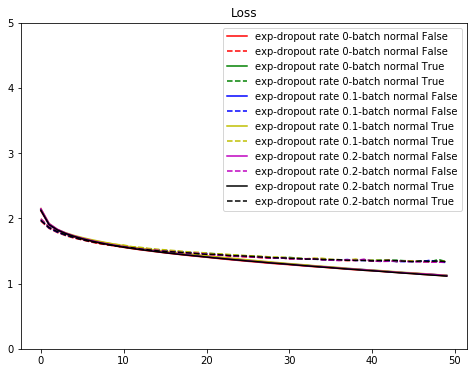

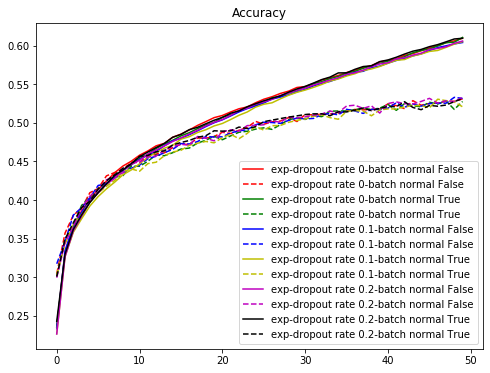

REGULARIZER=<function l1 at 0x0000023D208642F0>


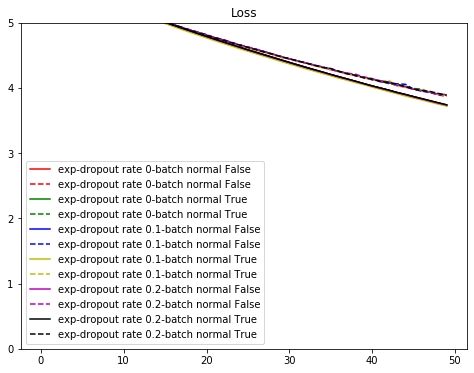

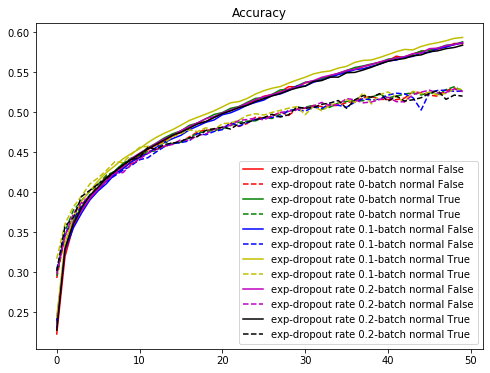

REGULARIZER=<function l2 at 0x0000023D20864620>


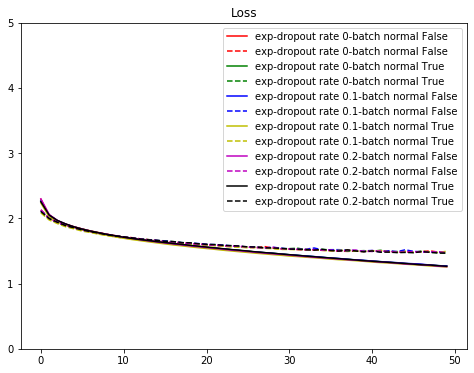

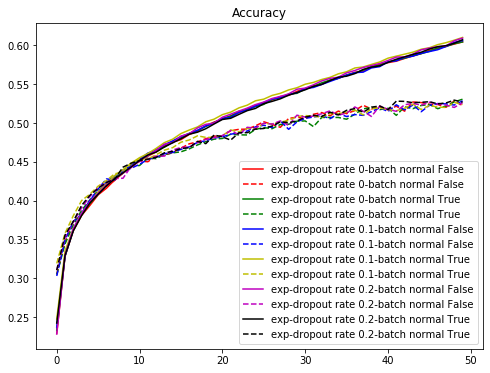

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
for i, regul in enumerate(REGULARIZER):
    print("REGULARIZER=%s" %(str(regul)))
    if i == 0:
        results = results1
    elif i == 1:
        results = results2
    elif i == 2:
        results = results3
    
    color_bar = ["r", "g", "b", "y", "m", "k"]

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()